In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

import sys
import os
sys.path.append(os.path.abspath('..'))

from PTA import PTA
from samples import Samples
import constants as c

from ent_data_simulation import params_injected

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

from emcee.autocorr import integrated_time
from time import perf_counter

%load_ext autoreload
%autoreload 2

In [2]:
# load Enterprise pulsar data
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
toas = jnp.array(data_dict['toas'])
residuals = jnp.array(data_dict['residuals'])
Tspans = toas[:, -1] - toas[:, 0]
Tspan = jnp.mean(Tspans)
Tspan_yr = Tspan / c.year_sec
Np = toas.shape[0]
Ntoas = toas.shape[1]
psr_pos = jnp.array(data_dict['psr_pos'])
psr_dists = jnp.array(data_dict['psr_dists'])
psr_dists_inj = psr_dists[0]
psr_dists_stdev = psr_dists[1]
Fs = jnp.array(data_dict['Fs'])
Ms = jnp.array(data_dict['Ms'])
Rs = jnp.array([jnp.eye(Ntoas) - M @ jnp.linalg.inv(M.T @ M) @ M.T
                for M in Ms])
U_s = jnp.array([jnp.linalg.svd(M)[0]
                 for M in Ms])
Gs = jnp.array([U[:, 8:] for U in U_s])
Ns = jnp.array(data_dict['Ns'])
Ntinvs = jnp.array([G @ jnp.linalg.inv(G.T @ N @ G) @ G.T
                    for G, N in zip(Gs, Ns)])
psr_names = data_dict['psr_names']
x_inj_dict = data_dict['x_inj'].item()

Np = toas.shape[0]
Ntoas = toas.shape[1]
Nf = params_injected.num_modes
Na = 2 * Nf

Vs = jnp.array([F.T @ Ntinv @ res for F, Ntinv, res in zip(Fs, Ntinvs, residuals)])
Ws = jnp.array([F.T @ Ntinv @ F for F, Ntinv in zip(Fs, Ntinvs)])

In [3]:
pta = PTA(Np=Np,
          Tspan_yr=15,
          Nf=params_injected.num_modes,
          model_wn=False,
          model_rn=params_injected.rn_model,
          model_gwb=params_injected.gwb_model,
          model_cw=params_injected.cw_model,
          Enterprise_bounds=True,
          Nf_cw=15,
          tref=params_injected.tref)

In [4]:
if Fs.shape == (Np, Ntoas, 0):
    freqs = jnp.arange(1, Nf + 1) / Tspan
    Fs = jnp.zeros((Np, Ntoas, Na))
    for i in range(Np):
        for j in range(Nf):
            Fs = Fs.at[i, :, 2 * j].set(jnp.sin(2. * jnp.pi * \
                                                            freqs[j] * toas[i]))
            Fs = Fs.at[i, :, 2 * j + 1].set(jnp.cos(2. * jnp.pi * \
                                                                freqs[j] * toas[i]))

In [5]:
# angles between pulsars
angles = np.zeros((Np, Np))
for i in range(Np):
    for j in range(i, Np):
        pos1 = psr_pos[i]
        pos2 = psr_pos[j]
        angles[i,j] = angles[j,i] = np.arccos(np.clip(np.dot(pos1, pos2), -1.0, 1.0))
angles = jnp.array(angles)

# Hellings-Downs weighting
alpha = np.zeros((Np, Np))
for i in range(Np):
    for j in range(Np):
        if i == j:
            alpha[i,j] = 1.
        else:
            ang = angles[i,j]
            beta = (1. - np.cos(ang)) / 2.
            alpha[i,j] = 1.5 * beta * np.log(beta) - 0.25 * beta + 0.5
alpha = jnp.array(alpha)
alpha_inv = jnp.linalg.inv(alpha)

In [6]:
rho_scale = (c.year_sec ** 3.) / (12. * (jnp.pi ** 2.) * Tspan)
rho_scale1 = Tspan / c.year_sec
arr = jnp.repeat(jnp.arange(1, Nf + 1), 2)
arr /= rho_scale1
arr = jnp.array(arr)


@jit
def get_rho_diag(hyper_params):
    logAmp, gamma = hyper_params
    Amp = 10. ** logAmp
    return (Amp ** 2.) * rho_scale * (arr **  (-gamma))

In [7]:
@jit
def transform_a(gwb_hypers, a_standard_flat):
    rho_diag_inj = get_rho_diag(gwb_hypers)
    phi = rho_diag_inj[:, None, None] * alpha[None, :, :]
    L_phi = jnp.linalg.cholesky(phi)
    a_standard = a_standard_flat.reshape((Na, Np))
    a_stacked = jnp.einsum('fij, fj->fi', L_phi, a_standard)
    return a_stacked.T.flatten()

@jit
def inv_transform_a(gwb_hypers, a_flat):
    rho_diag_inj = get_rho_diag(gwb_hypers)
    phi = rho_diag_inj[:, None, None] * alpha[None, :, :]
    L_inv_phi = jnp.linalg.inv(jnp.linalg.cholesky(phi))
    a = a_flat.reshape((Na, Np))
    a_stacked = jnp.einsum('fij, fj->fi', L_inv_phi, a)
    return a_stacked.T.flatten()

In [8]:
# injected / MAP parameters
a_MAP = jnp.array([jnp.linalg.inv(W + jnp.diag(1. / get_rho_diag(params_injected.GWB_hypers_inj))) @ (V)
                   for W, V in zip(Ws, Vs)])
init_dict = {'gwb_hypers':jnp.array(params_injected.GWB_hypers_inj),
             'a_standard':inv_transform_a(params_injected.GWB_hypers_inj, a_MAP.flatten()),
            }
x_inj_arr = jnp.concatenate((init_dict['gwb_hypers'], a_MAP.flatten()))

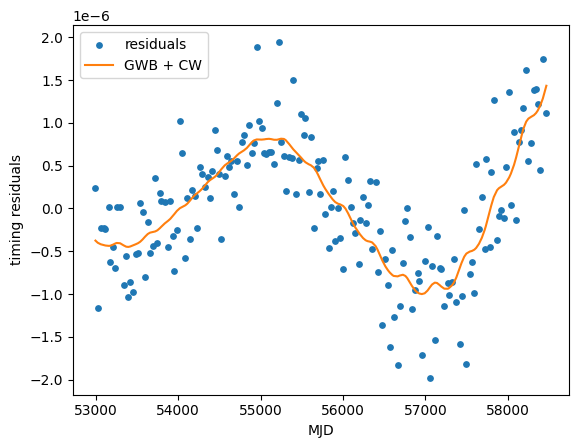

In [9]:
psr_ndx = 0
plt.scatter(toas[psr_ndx] / 86400., residuals[psr_ndx], color='C0', label='residuals', s=15)
plt.plot(toas[psr_ndx] / 86400., Rs[psr_ndx] @ Fs[psr_ndx] @ a_MAP[psr_ndx],
         color='C1', label='GWB + CW')
plt.legend()
plt.xlabel('MJD')
plt.ylabel('timing residuals')
plt.show()

In [10]:
@jit
def lnlike_per_psr(V, W, a_per_psr):
    return V.T @ a_per_psr - 0.5 * a_per_psr.T @ W @ a_per_psr

vectorized_lnlike_per_psr = jit(vmap(lnlike_per_psr, in_axes=(0, 0, 0)))

@jit
def lnlike(a):
    a_stacked = a.reshape((pta.Np, pta.Na))
    return jnp.sum(vectorized_lnlike_per_psr(Vs, Ws, a_stacked))

In [11]:
def sampling_model():
    
    # RN hyper-parameter have uniform prior
    gwb_hypers = numpyro.sample('gwb_hypers', dist.Uniform(pta.gwb_mins, pta.gwb_maxs))
    
    # draw Fourier coefficients from Gaussian prior
    a_standard = numpyro.sample('a_standard', dist.Normal().expand((pta.Na_PTA,)))
    a = transform_a(gwb_hypers, a_standard)
    numpyro.deterministic('a', a)

    # likelihood
    numpyro.factor('ln_likelihood', lnlike(a))

In [13]:
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True,
                                 init_strategy=init_to_value(values=init_dict),
                                 )
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(2e3),
                          num_samples=int(5e6))

time_start = perf_counter()
mcmc.run(jr.key(11))
time_stop = perf_counter()

sample: 100%|██████████| 5002000/5002000 [3:30:41<00:00, 395.69it/s, 15 steps of size 2.87e-01. acc. prob=0.84]  


In [14]:
# convert dictionary of samples into array
samples_dict = mcmc.get_samples()
samples = np.concatenate((samples_dict['gwb_hypers'],
                          samples_dict['a']),
                          axis=1)

In [15]:
hmc_samples = Samples(samples_arr=samples,
                      labels=pta.x_labels,
                      x_inj=x_inj_arr,
                      jax=True)

In [16]:
int_time = np.max(integrated_time(hmc_samples.samples, has_walkers=False))
effective_sample_size = np.round(hmc_samples.samples.shape[0] / (2 * int_time))
duration = time_stop - time_start
ESS_per_sec = effective_sample_size / duration
print(f'effective sample size / sec = {ESS_per_sec}')

effective sample size / sec = 46.59734449105319


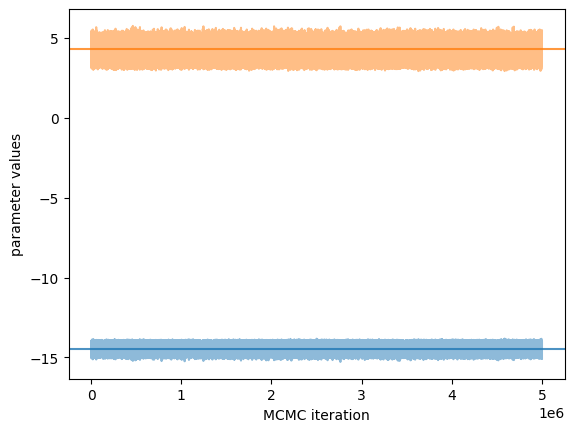

In [17]:
hmc_samples.trace_plt(param_ndxs=pta.gwb_ndxs)

In [21]:
# load samples from Enterprise run
ent_df = pd.read_pickle("ent_df.pkl.gz", compression="gzip")

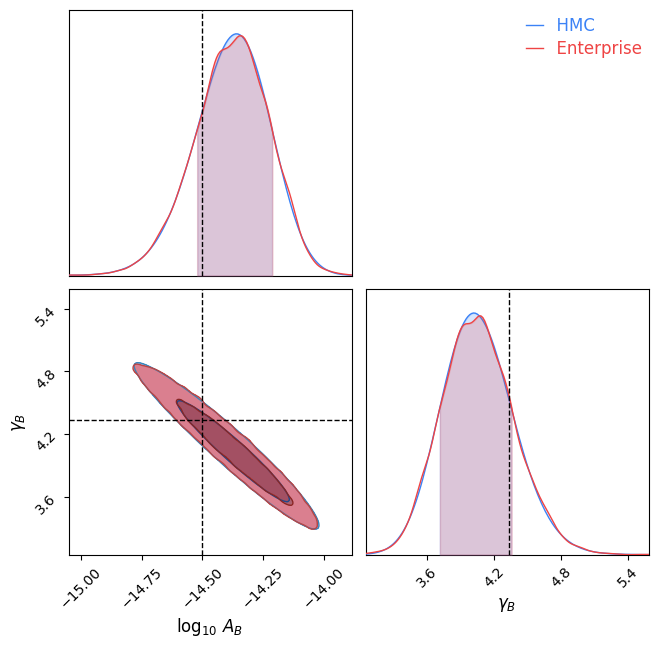

In [22]:
# red noise corner plot
ndxs = np.r_[:2]
gwb_labels = np.array(['log10_A_gw', 'gamma_gw'])
new_gwb_labels = np.array([r'$\log_{{{10}}}\,A_B$', r'$\gamma_B$'])
gwb_df = pd.DataFrame(hmc_samples.samples[:, pta.gwb_ndxs], columns=new_gwb_labels)
ent_df = ent_df.rename(columns={old: new for old, new in zip(gwb_labels.T, new_gwb_labels.T)})

gwb_label_mapping = dict(zip(gwb_labels, new_gwb_labels))
x_inj_dict = {gwb_label_mapping.get(k, k): v for k, v in x_inj_dict.items()}

c = ChainConsumer()
c.add_chain(Chain(samples=gwb_df[new_gwb_labels[ndxs]], name='HMC', color='blue'))
c.add_chain(Chain(samples=ent_df[new_gwb_labels[ndxs]], name='Enterprise', color='red'))
c.add_truth(Truth(location=x_inj_dict))
# c.set_plot_config(PlotConfig(legend_kwargs={'fontsize': 30}))
fig = c.plotter.plot()